In [87]:
import os
import json
import numpy as np
from rdkit import Chem

from matplotlib import pyplot as plt
import pandas as pd

In [2]:
gnps_dir = "G:\\Dev\\Data\\GNPS"
json_file_dir = "G:\\Dev\\trees_gnps"
fragments_occurences = "G:\\Dev\\fragment_occurences.csv"
losses_occurences = "G:\\Dev\\losses_occurences.csv"

path = "G:\\Dev\\CSIFingerID\\"
sample_fingerprints_legend_path = path + "fingerprints.csv"
output_file_dir = path + "all_sirius_output_minibatches"

In [3]:
fragments_df = pd.read_csv(fragments_occurences, names=["formula", "occurences"])
fragments_df = fragments_df.set_index("formula")
losses_df = pd.read_csv(losses_occurences, names=["formula", "occurences"])
losses_df = losses_df.set_index("formula")


In [4]:
losses_df.index = [index + "_loss" for index in losses_df.index]
print(losses_df.index)
combined_index = fragments_df.index.union(losses_df.index)
print(combined_index)

Index(['CO_loss', 'H2O_loss', 'C2H2_loss', 'CH3_loss', 'CHN_loss', 'CH4_loss',
       'H3N_loss', 'H2_loss', 'C2H4_loss', 'C2H2O_loss',
       ...
       'C3H8S_loss', 'OP_loss', 'CH2N3_loss', 'C7H7NO3_loss', 'O2P_loss',
       'C2H5NOS_loss', 'C10H4N3_loss', 'C9H17O3_loss', 'C3H7N4_loss',
       'C4H6NO2_loss'],
      dtype='object', length=892)
Index(['BrH_loss', 'Br_loss', 'C10', 'C10H10', 'C10H10ClN', 'C10H10ClNO',
       'C10H10ClNO2', 'C10H10F2O2', 'C10H10FN', 'C10H10N',
       ...
       'O2_loss', 'O3S_loss', 'O3_loss', 'O4_loss', 'O5_loss', 'OP_loss',
       'OS_loss', 'O_loss', 'S2_loss', 'S_loss'],
      dtype='object', length=5508)


In [5]:
spectrum_smiles = {}
spectrum_formula = {}

for file in os.listdir(gnps_dir):
    filepath = os.path.join(gnps_dir, file)
    with open(filepath, 'r') as f:
        content = f.readlines()
        smiles = content[6].split(" ")[1]
        formula = content[1].split(" ")[1]
        mol_name = file[:-3]
        spectrum_smiles[mol_name] = smiles
        spectrum_formula[mol_name] = formula

In [6]:
def read_tree(filepath, fragment_formula, losses_formula):
    fragments = {}
    losses = {}
    
    with open(filepath, 'r') as f:
        data = json.load(f)

    for fragment in data['fragments']:
        if fragment['molecularFormula'] in fragment_formula:
            if "intensity" in fragment:
                fragments[(fragment['molecularFormula'])] = float(fragment['intensity'])

    for loss in data['losses']:
        loss_index = loss['molecularFormula'] + "_loss"
        if loss["source"] in fragments and loss["target"] in fragments and loss_index in losses_formula:
            losses[loss_index] = (fragments[loss["source"]] + fragments[loss["target"]]) /2 
        
    return fragments, losses

In [7]:
print(losses_df.index)

Index(['CO_loss', 'H2O_loss', 'C2H2_loss', 'CH3_loss', 'CHN_loss', 'CH4_loss',
       'H3N_loss', 'H2_loss', 'C2H4_loss', 'C2H2O_loss',
       ...
       'C3H8S_loss', 'OP_loss', 'CH2N3_loss', 'C7H7NO3_loss', 'O2P_loss',
       'C2H5NOS_loss', 'C10H4N3_loss', 'C9H17O3_loss', 'C3H7N4_loss',
       'C4H6NO2_loss'],
      dtype='object', length=892)


In [8]:
filepath = os.path.join(json_file_dir, "CCMSLIB00000001563.json")
fragments, losses = read_tree(filepath, fragments_df.index, losses_df.index)
print(fragments)
print(losses)

{'C16H24N2O4': 6160.996094, 'C15H24N2O3': 16870.810547, 'C14H18N2O3': 2070.579102, 'C14H16N2O2': 809.072083, 'C11H17NO3': 21815.289062, 'C11H15NO2': 64301.03125, 'C10H17NO2': 14258.55957, 'C10H15NO': 6297.509766, 'C6H13N': 15535.5, 'C8H9NO2': 1387.92395, 'C8H8NO2': 1246.405029, 'C7H8NO': 845.15387, 'C6H7NO2': 2094.37793, 'C13H15NO2': 2861.543945, 'C13H16N2O': 1143.875977, 'C13H13NO': 1225.858032, 'C12H13N': 3435.073975, 'C8H9N': 6533.36377, 'C15H22N2O': 1184.531006}
{'CO_loss': 2330.4660034999997, 'C2H6O_loss': 4115.787598, 'H2O_loss': 2043.7009885, 'C3HN_loss': 11942.934082, 'C4H4O2_loss': 14897.029784999999, 'C3H6_loss': 32844.4776, 'C3H7_loss': 32773.7181395, 'C2H2_loss': 1741.15094, 'CHN_loss': 1835.308014, 'C4H4_loss': 4984.2188725}


In [89]:
def dict_is_empty(sample_dict):
    return len(sample_dict.keys()) == 0

def get_mol_names(path_dir):
    return [file[:-3] for file in os.listdir(path_dir)]

def load_tree(path_dir):
    mol_ids = get_mol_names(path_dir)
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=combined_index, dtype=float)
    for file in os.listdir(path_dir):
        mol_name = file[:-3]
        tree_path = json_file_dir + os.sep + mol_name + ".json"
        fragments, losses = read_tree(tree_path, fragments_df.index, losses_df.index)
        if dict_is_empty(fragments) or dict_is_empty(losses):
            intensities.drop([mol_name], inplace=True)
        else:
            for fragment, intensity in fragments.items():
                intensities.at[mol_name, fragment] = float(intensity)
            for fragment, intensity in losses.items():
                intensities.at[mol_name, fragment] = float(intensity)
            intensities.loc[mol_name] = intensities.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
    return intensities

def load_fingerprints(mol_ids, fingerprint_smarts):
    fingerprints = pd.DataFrame(0, index=mol_ids, columns=range(154), dtype=int)
    for index in fingerprints.index:
        smiles = spectrum_smiles[index]
        m = Chem.MolFromSmiles(smiles)
        for i, smarts in enumerate(fingerprint_smarts):
            patt = Chem.MolFromSmarts(smarts)
            fingerprints.at[index, i] = int(m.HasSubstructMatch(patt))
            
    return fingerprints

def load_csi_fingerprints(output_file_dir, mol_folder_file, gnps_mol_ids):
    mol_ids = [entry[1] for entry in mol_folder_file if entry[1] in gnps_mol_ids]
    fingerprints = pd.DataFrame(0, index=mol_ids, columns=range(154), dtype=float)
    for directory, mol, formula in mol_folder_file:
        if mol in gnps_mol_ids:
            file_dir = os.path.join(output_file_dir, directory)
            folder = "1_{0}_{1}".format(directory, mol)
            fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
            fingerprint_file = os.listdir(fingerprints_file_dir)[1]
            full_fingerprint_filepath = os.path.join(fingerprints_file_dir, fingerprint_file)
            with open(full_fingerprint_filepath, 'r') as f:
                content = f.readlines()
                rel_content = content[:154]
                for index, prediction in enumerate(rel_content):
                    fingerprints.at[mol, index] = float(prediction[:-1])

    return fingerprints

In [10]:
intensities = load_tree(gnps_dir)
print(intensities)

                    BrH_loss  Br_loss  C10      C10H10  C10H10ClN  C10H10ClNO  \
CCMSLIB00000001563       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001566       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001570       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001574       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001576       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001590       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001598       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001600       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001606       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001609       0.0      0.0  0.0    0.000000        0.0         0.0   
CCMSLIB00000001615       0.0      0.0  0.0  121.362059        0.0         0.0   
CCMSLIB00000001616       0.0

In [31]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def fragments_shifts_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(2500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(1000,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(500,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

Using TensorFlow backend.


In [12]:
def file_has_fingerprint(file_content):
    return "fingerprints.csv" in file_content

def file_incomplete(file_content):
    return len(file_content) <= 2

def retrieve_fingerprint_file(formula, folder):
    content = os.listdir(folder)
    return next((filename for filename in content if formula in filename), None)

In [13]:
desc_list = []

with open(sample_fingerprints_legend_path, 'r') as f:
    for line in f:
        rel_index, abs_index, desc = line.split("\t")
        if desc[:-1] != "description":
            desc_list.append(desc[:-1])

desc_list = desc_list[:154]
fingerprint_smarts = [entry.split(" ")[0] for entry in desc_list]

In [14]:
correct_folder_file = []
wrong_folder_file = []

for directory in os.listdir(output_file_dir):
    file_dir = os.path.join(output_file_dir, directory)
    files_in_output_dir = os.listdir(file_dir)
    if file_has_fingerprint(files_in_output_dir):
        mol = files_in_output_dir[1].split("_")[-1]
        folder = "1_{0}_{1}".format(directory, mol)
        fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
        if mol in spectrum_formula:
            formula = spectrum_formula[mol]
            if retrieve_fingerprint_file(formula, fingerprints_file_dir):
                correct_folder_file.append((directory, mol, formula))
            else:
                wrong_folder_file.append((directory, mol, formula))

In [73]:
wrong_mol_names = [stuff[1] for stuff in wrong_folder_file]

In [45]:
intensities.sort_index(inplace=True)
train_tree = intensities[~intensities.index.isin(wrong_mol_names)]
x_train_tree = np.log(train_tree.values+1)
print(x_train_tree.shape)
N,M = x_train_tree.shape

shuffle_order = np.random.permutation(N)

#train without the 77 for wrong
fingerprints = load_fingerprints(train_tree.index, fingerprint_smarts)
fingerprints.sort_index(inplace=True)
x_train_fingerprints = fingerprints.values

(5092, 5508)


In [58]:
epochs = 100
mod = fragments_shifts_model(x_train_tree, x_train_fingerprints)
mod.fit(x_train_tree[shuffle_order],x_train_fingerprints[shuffle_order],epochs=epochs,validation_split=0.2,verbose=0)

In [59]:
test_tree = intensities[intensities.index.isin(wrong_mol_names)]
predicted = mod.predict(test_tree.values)

In [60]:
print(test_tree.values)
print(len(predicted))

[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 427.29387259   0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
   61.91977612]]
55


In [61]:
test_fingerprints = load_fingerprints(test_tree.index, fingerprint_smarts)
test_fingerprints.sort_index(inplace=True)
x_test_fingerprints = test_fingerprints.values

In [70]:
from sklearn import metrics
def compute_auc(bits, true, pred, num_samples=0, permutations=500):
    val_start_index = 0
    if num_samples > 0:
        val_start_index = int(num_samples - (num_samples * val_fraction) - 1)  # Index where validation samples begin.

    num_permutations = permutations  # Number of permutations to compute AUC scores for.

    # Create structured array to hold statistics for each.
    dtype = [('fp_id', int), ('nonzeros', int), ('auc', float), ('auc_percent', float)]
    mol_stats = np.zeros((bits,), dtype=dtype)
    # Create array to hold permutation AUC scores for plotting.
    perm_scores = np.zeros((bits, num_permutations))

    for fp_id in range(true.shape[1]):  # For every substructure
        nonzero_vals = np.count_nonzero(true[val_start_index:, fp_id])  # Count number of nonzero values
        if 0 < nonzero_vals < true[val_start_index:, fp_id].size:  # If there are no 1s or no 0s, can't compute.
            # Compute actual AUC score using only the validation fraction of the dataset.
            fp_true = true[val_start_index:, fp_id]
            fp_pred = pred[val_start_index:, fp_id]
            score = metrics.roc_auc_score(fp_true, fp_pred)

            # Compute AUC scores for permutations and compare to actual.
            counter = 0
            for i in range(num_permutations):
                permutation = np.random.permutation(fp_true)
                perm_score = metrics.roc_auc_score(permutation, fp_pred)
                perm_scores[fp_id, i] = perm_score
                # Count how many permutations have a higer AUC score than actual data.
                if perm_score >= score:
                    counter = counter + 1
            # Calculate % of scrambled values with higher AUC score than actual AUC
            percentage = (counter / num_permutations) * 100
            # Update structured array with data or non values if no AUC could be calculated.
            mol_stats[fp_id] = fp_id, nonzero_vals, score, percentage
        else:
            mol_stats[fp_id] = (fp_id, nonzero_vals, 0, 100)

    # Permutations take a while, print statement to say when finished.
    print("Done")
    return mol_stats, perm_scores

In [71]:
baseline_stats, baseline_perm_scores = compute_auc(154, x_test_fingerprints, predicted)

Done


In [90]:
csi_fingerprints = load_csi_fingerprints(output_file_dir, wrong_folder_file, intensities.index)
csi_fingerprints.sort_index(inplace=True)
print(csi_fingerprints.shape)

(55, 154)


In [91]:
exp_stats, exp_perm_scores = compute_auc(154, x_test_fingerprints, csi_fingerprints.values)

Done


In [92]:
def evaluate(base_stats, base_perm_scores, exp_stats, exp_perm_scores, names):
    # Sort molecules in ascending order of baseline AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((base_stats['auc'] > 0.5))
    abnormal_auc = np.where((base_stats['auc']) < 0.5)
    ordered_base = np.sort(base_stats[normal_auc], order='auc', axis=0)[::-1]

    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_base[:30]
    sample_fps = np.append(sample_fps, ordered_base[-5:])

    # Plot number of substructures with AUC scores above 0.7 and above 0.5 for both data sets
    base_above_07 = len(np.where((base_stats['auc'] >= 0.7))[0])
    exp_above_07 = len(np.where((exp_stats['auc'] >= 0.7))[0])
    base_above_05 = len(np.where((base_stats['auc'] >= 0.5))[0])
    exp_above_05 = len(np.where((exp_stats['auc'] >= 0.5))[0])

    fig, ax = plt.subplots()
    index = np.arange(2)
    bar_width = 0.35
    opacity = 0.5
    ax.bar(index, (base_above_05, base_above_07), bar_width, alpha=opacity, color='b', label='Baseline')
    ax.bar(index + bar_width, (exp_above_05, exp_above_07), bar_width, alpha=opacity, color='r', label='Experiment')

    ax.set_xlabel('AUC Threshold')
    ax.set_ylabel('Number of Substructures')
    ax.set_title('AUC Score Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(('Above 0.5', 'Above 0.7'))
    ax.legend()

    plt.show()

    # Boxplots of sample substructures for both data sets
    boxplots(base_stats, base_perm_scores, sample_fps, names)
    boxplots(exp_stats, exp_perm_scores, sample_fps, names)
    tandem_boxplots(base_stats, base_perm_scores, exp_stats, sample_fps, names)

    # Sort molecules in ascending order of experimental AUC score, keeping only molecules with AUC scores above 0.5
    normal_auc = np.where((exp_stats['auc'] > 0.5))
    abnormal_auc = np.where((exp_stats['auc']) < 0.5)
    ordered_exp = np.sort(exp_stats[normal_auc], order='auc', axis=0)[::-1]

    # Take top 30 and bottom 5 substructures by AUC score to use for boxplots.
    sample_fps = ordered_exp[:30]
    sample_fps = np.append(sample_fps, ordered_exp[-5:])

    boxplots(base_stats, base_perm_scores, sample_fps, names)
    boxplots(exp_stats, exp_perm_scores, sample_fps, names)
    tandem_boxplots(base_stats, exp_perm_scores, exp_stats, sample_fps, names)

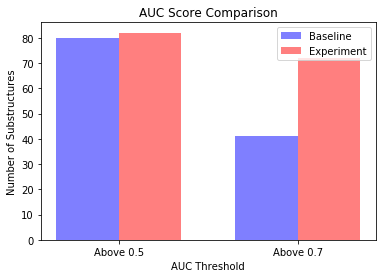

NameError: name 'boxplots' is not defined

In [93]:
evaluate(baseline_stats, baseline_perm_scores, exp_stats, exp_perm_scores, range(154))